In [ ]:
# default_exp bayesian_hacker_AB_testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
%matplotlib inline
from IPython.core.pylabtools import figsize

## A Simple Case

In [ ]:
# The parameters are the bounds of the Uniform
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1) # p_A distribution

In [ ]:
# Assumption of the data-generation step
p_true = 0.05 # This is unknown, just an assumption of TRUE p_A
N = 1500 # N users shown site A

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
72


In [ ]:
# The observed frequency is
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0480
Does this equal the true frequency? False


In [ ]:
# Including the observed data into the Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    step = pm.Metropolis() # Sampling step
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

<ipython-input-21-aac70e6274c6>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(18000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


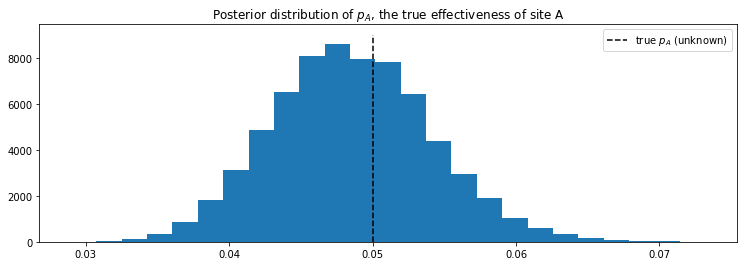

In [ ]:
# Plot the posterior distribution of the unkown p_A
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 9000, linestyle="--", label="true $p_A$ (unknown)", colors="black")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled")
plt.legend()

## A and B Together

In [ ]:
## Generate some observed data

# Assume two unknown p_A and p_B
true_p_A = 0.05
true_p_B = 0.04

# Using unqeual sample sizes
N_A = 1500 # Number of users using site A
N_B = 750  # Number of users using site B

# Generate some observations
obs_A = stats.bernoulli.rvs(true_p_A, size=N_A)
obs_B = stats.bernoulli.rvs(true_p_B, size=N_B)

print("Obs from Site A: ", obs_A[:30], "...", " Mean: ", np.mean(obs_A))
print("Obs from Site B: ", obs_B[:30], "...", " Mean: ", np.mean(obs_B))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...  Mean:  0.05466666666666667
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...  Mean:  0.04666666666666667


In [ ]:
# Setup model
with pm.Model() as model:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)
    
    AB_diff = pm.Deterministic('AB_diff', p_A - p_B)
    
    obs_A = pm.Bernoulli('obs_A', p_A, observed=obs_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed=obs_B)
    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    

<ipython-input-55-0f5255ae5233>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
trace.varnames, trace.stat_names

(['p_A_interval__', 'p_B_interval__', 'p_A', 'p_B', 'AB_diff'],
 {'accept', 'accepted', 'scaling', 'tune'})

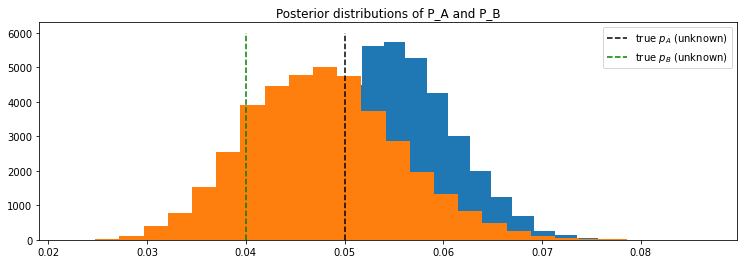

In [ ]:
# Plot the posterior distribution of the unkown p_A
figsize(12.5, 4)
plt.title("Posterior distributions of P_A and P_B")
plt.vlines(true_p_A, 0, 6000, linestyle="--", label="true $p_A$ (unknown)", colors="black")
plt.vlines(true_p_B, 0, 6000, linestyle="--", label="true $p_B$ (unknown)", colors="green")
plt.hist(trace["p_A"], bins=25, histtype="stepfilled")
plt.hist(trace["p_B"], bins=25, histtype="stepfilled")
plt.legend()

<AxesSubplot:title={'center':'x'}>

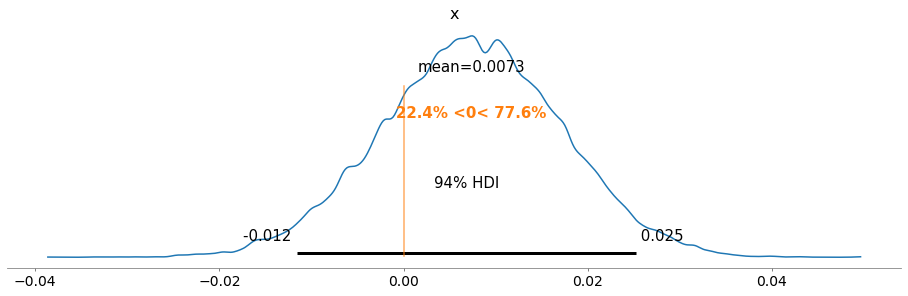

In [ ]:
pm.plot_posterior(trace["AB_diff"], ref_val=0)

In [ ]:
delta_samples = trace["AB_diff"]
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.224
Probability site A is BETTER than site B: 0.776
